# Tessera Modelling
---
This notebook aims to model through a Random Forest model any category of land cover using the ESA World Cover as reference and all the TESSERA dimensions as predictors.

The user has to provide:
1. The path to TESSERA merged tiles of the AOI
2. The path to the corresponding ESA World Cover
3. The value of the category of interest (e.g. 50 for urban land cover)
4. The sample size for the category of interest
5. The test size ratio
6. The path to the output folder and the basename of the model file in case the user wants to save the model

This notebook uses:
- rasterio
- sklearn
- Other typical Python libraries for data handling, analysis, and visualization.

Contact: pablo.timoner@unige.ch

In [58]:
# Required libraries
import os
import random
import numpy as np
import rasterio
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling as ResampleEnum
from rasterio.transform import from_origin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [79]:
# User parameters
mosaic_path = "../geotessera/Berchidda/mosaic.tif"
esa_path    = "../ESA/ESA_WorldCover_10m_2021_v200_N39E009_Map.tif"
cat_value = 50
sample_size = 20000
test_size = 0.3
save_model = True
output_dir = "./"
model_name = "rf_Berchidda"

In [62]:
# Desired sample sizes
n_true = n_false = sample_size

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

# Open mosaic to get target grid (CRS, transform, shape)
with rasterio.open(mosaic_path) as src_m:
    m_crs = src_m.crs
    m_transform = src_m.transform
    m_width = src_m.width
    m_height = src_m.height
    m_count = src_m.count  # number of bands
    # Read all bands into memory as (bands, h, w) numpy array
    mosaic_arr = src_m.read()
    
print("TESSERA CRS:", m_crs, "shape:", mosaic_arr.shape)

TESSERA CRS: EPSG:32632 shape: (128, 6678, 5923)


In [63]:
# Read ESA WorldCover and reproject/resample to mosaic grid
# We'll produce an integer array (single-band) aligned with mosaic transform/resolution/shape.
esa_reproj = np.empty((m_height, m_width), dtype=np.int16)

with rasterio.open(esa_path) as src_e:
    e_crs = src_e.crs
    print("ESA CRS:", e_crs, "ESA shape:", src_e.width, src_e.height)

    # Prepare destination metadata: dtype int16 (WorldCover uses small ints)
    dst_transform = m_transform
    dst_crs = m_crs
    dst_width = m_width
    dst_height = m_height

    # Reproject into the mosaic grid
    reproject(
        source=rasterio.band(src_e, 1),
        destination=esa_reproj,
        src_transform=src_e.transform,
        src_crs=src_e.crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        dst_resolution=None,
        resampling=Resampling.nearest
    )

# Now 'esa_reproj' is aligned with mosaic grid (rows, cols match)
print("Reprojected ESA shape:", esa_reproj.shape, "unique values sample:", np.unique(esa_reproj)[:10])

ESA CRS: EPSG:4326 ESA shape: 36000 36000
Reprojected ESA shape: (6678, 5923) unique values sample: [10 20 30 40 50 60 80 90]


In [66]:
nodata = None
with rasterio.open(esa_path) as src_e:
    nodata = src_e.nodata
print("ESA original nodata:", nodata)

# Create boolean masks (only include pixels that are not nodata if nodata known)
if nodata is not None:
    valid_mask = esa_reproj != nodata
else:
    # If nodata unknown, consider everything valid
    valid_mask = np.ones_like(esa_reproj, dtype=bool)

true_mask = (esa_reproj == 50) & valid_mask
false_mask = (esa_reproj != 50) & valid_mask

n_true_total = int(np.count_nonzero(true_mask))
n_false_total = int(np.count_nonzero(false_mask))

print(f"Pixels available for presence (value = {cat_value}): {n_true_total}, Pixels available for absence (value != {cat_value}): {n_false_total}")

ESA original nodata: 0.0
Pixels available for presence (value = 50): 593026, Pixels available for absence (value != 50): 38960768


In [67]:
# Sample coordinates (row,col) for each class
def sample_indices_from_mask(mask, n_samples):
    idxs = np.flatnonzero(mask)
    if len(idxs) == 0:
        return np.array([], dtype=int)
    take = min(n_samples, len(idxs))
    chosen = np.random.choice(idxs, size=take, replace=False)
    # Convert flat index back to 2D row,col
    rows, cols = np.unravel_index(chosen, mask.shape)
    return rows, cols

true_rows, true_cols = sample_indices_from_mask(true_mask, n_true)
false_rows, false_cols = sample_indices_from_mask(false_mask, n_false)

print("Sampled presences:", len(urban_rows), "Sampled absences:", len(neg_rows))

Sampled presences: 20000 Sampled absences: 20000


In [70]:
# Extract directly from mosaic_arr which shares the same grid
# mosaic_arr shape: (bands, height, width)
def extract_values_from_mosaic(rows, cols, mosaic_arr):
    vals = np.stack([mosaic_arr[:, r, c] for r, c in zip(rows, cols)], axis=0)
    return vals

true_vals = extract_values_from_mosaic(true_rows, true_cols, mosaic_arr)
false_vals = extract_values_from_mosaic(false_rows, false_cols, mosaic_arr)

print("true_vals shape:", urban_vals.shape, "false_vals shape:", neg_vals.shape)

true_vals shape: (20000, 128) false_vals shape: (20000, 128)


In [71]:
# Create a data frame that is going to be used for modelling
n_bands = mosaic_arr.shape[0]
band_cols = [f"B{i+1}" for i in range(n_bands)]

df_pos = pd.DataFrame(true_vals, columns=band_cols)
df_pos['y'] = 1

df_neg = pd.DataFrame(false_vals, columns=band_cols)
df_neg['y'] = 0

df = pd.concat([df_pos, df_neg], ignore_index=True)
print("Final dataframe shape:", df.shape)
display(df.head(5))

Final dataframe shape: (40000, 129)


,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,...,B120,B121,B122,B123,B124,B125,B126,B127,B128,y
0,1.945819,1.545209,1.030139,5.036236,0.400610,-1.659669,1.602439,-0.858449,1.201829,3.262108,...,-4.463937,-1.888589,-3.204878,4.463937,-3.605487,-3.948867,1.487979,2.975958,2.117508,1
1,2.072774,0.859443,-0.556110,0.000000,0.960554,-2.831106,0.808887,0.000000,-0.606666,3.184994,...,-1.415553,-1.061665,-3.690549,2.527773,-2.578329,-3.993882,2.578329,2.022218,-0.505555,1
2,2.947669,2.225791,-0.481252,1.443756,1.323443,-2.285947,0.902348,-1.985165,-0.842191,4.632051,...,-1.022661,-2.586730,-3.549234,3.489077,-0.962504,-5.053146,1.142974,1.744539,1.082817,1
3,-0.847438,-4.660909,-0.988678,6.638265,-0.847438,2.895413,8.827479,0.070620,4.025331,2.401074,...,-8.474380,-0.776818,5.932066,-1.977355,-6.214546,-4.943388,2.118595,8.121282,-1.341777,1
4,5.600747,2.006238,-0.167186,2.758577,3.009357,-2.507797,-2.173424,-0.835932,0.334373,3.761696,...,-1.170305,-1.588272,-2.340611,1.337492,0.334373,-6.436680,-0.167186,0.417966,1.086712,1


In [50]:
# 7) (Optional) Save dataframe to CSV
out_csv = os.path.join("..", f"sampled_pixels_{n_pos}_{n_neg}.csv")
df.to_csv(out_csv, index=False)
print("Saved sample CSV to:", out_csv)

Saved sample CSV to: ../sampled_pixels_20000_20000.csv


In [73]:
# Features (all bands) and target
X = df.drop(columns=["y"])
y = df["y"]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (16000, 128) Test: (24000, 128)


In [74]:
# Get total number of CPU cores
total_cores = os.cpu_count()

# Use one third of them (at least 1 core)
n_jobs = max(1, total_cores // 3)

# Modelling
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,     
    n_jobs=n_jobs,       
    random_state=42
)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Classification Report:

              precision    recall  f1-score   support

           0      0.962     0.970     0.966     12000
           1      0.970     0.961     0.966     12000

    accuracy                          0.966     24000
   macro avg      0.966     0.966     0.966     24000
weighted avg      0.966     0.966     0.966     24000

ROC AUC: 0.991
Sensitivity: 0.961
Specificity: 0.970
TSS: 0.931


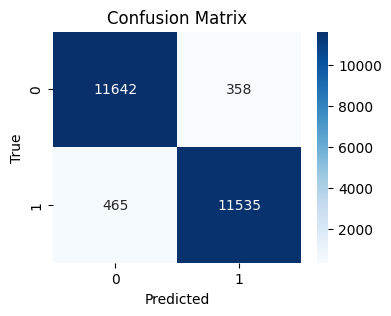

In [78]:
# Evaluate
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute sensitivity (recall for positive class)
sensitivity = tp / (tp + fn)

# Compute specificity (true negative rate)
specificity = tn / (tn + fp)

# Compute TSS
tss = sensitivity + specificity - 1

print(f"ROC AUC: {auc:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"TSS: {tss:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [80]:
# Save the model
if save_model:  
    # Make sure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Full path to save the model
    model_path = os.path.join(output_dir, model_name)
    
    # Save the Random Forest model
    joblib.dump(rf, model_path)
    
    print(f"Model saved to: {model_path}")


Model saved to: ./rf_Berchidda
